In [20]:
# Libraries
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import helperfunctions as hf
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold
from IPython.core.interactiveshell import InteractiveShell

# Notebook Settings 
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("error")
pd.set_option('display.max_columns', 500)
InteractiveShell.ast_node_interactivity = "all"
%load_ext autoreload
%autoreload 2

# Variables
crop_seasons = list(range(1993,2017))
months_of_crop_season = list(range(4,12))
homogeneous_groups = list(range(1,5))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Content
* [1. Read Data](#read_data)
* [2. Bias-Adjustment](#bias_adjustment)
* [3. Dataset Completion](#dataset_completion)
* [4. Feature Preparation](#feature_preparation)
* [5. Include Yield Data](#yield_data)
* [6. K-Fold Cross Validation](#cross_validation)
* [7. Visualization](#visualization)

## Abstract

The amount of wheat imports to Brazil depend on its national production. Wheat production failures and price increases can be anticipated before harvest with wheat yield forecast systems. The goal of this study was to analyze how seasonal climatology_copy models can be useful to forecast national trend-corrected wheat yield in Brazil. We used monthly aggregated temperature and precipitation data during the last three months of the wheat growing season from August to October to train a ridge regression model. The studied climatology_copy models were from the European Center for Medium-Range Weather Forecasts (ECMWF), the National Centers for Environmental Prediction (NCEP), and the UK-based Met Office (UKMO). We further tested a multi-model ensembles (MME) approach of the three climate models as well as a climatological approach, whose forecasts for each site, and month is based on historical climate. For every season from 1993-2016, we initialized forecasts at the beginning of each month during the crop season from April to October. From August on, we supplemented climate features from past months with observations. Wheat yield anomaly forecasts improved towards harvest. For some models and month of forecast initialization, the climatological approach performed better than single seasonal climate models. However, the multi-model ensemble as well as the ECMWF-based wheat yield forecasts consistently outperformed climatology and two months before harvest wheat yield could be forecasted with 9%, 9.1%, and 10.1% RMSE respectively. Our results demonstrated that seasonal climate models and their aggregation to multi-model ensembles provide valuable information to anticipate possible wheat production shortcomings in Brazil.

## 1. Read Data <a name="read_data"></a>

Our approach requires three sources of climate data: seasonal climate models (hindcasts), observations, and climatology.
- **hindcasts**: There are three seasonal climate models that we requested data from: ECMWF, UKMO, NCEP. We also computed an unweighted average of the outputs of the three climatology_copy models to have a multi-model ensemble output (MME). We requested retrospective seasonal climatology_copy forecasts, called hindcasts from 1993 to 2016 for four locations (zones) in Brazil. The locations were selected based on the findings from Nóia Júnior et al. ([2021](https://iopscience.iop.org/article/10.1088/1748-9326/ac26f3)). For each model, year, and location, we requested seven hindcasts, initialized at the beginning of each month during the wheat growing season from April to October and forecasting precipitation and temperature data until the end of the season.
- **observations**: We also need climate observations from the same four locations ([Nóia Júnior et al., 2021](https://iopscience.iop.org/article/10.1088/1748-9326/ac26f3)) from 1993 to 2016 along the wheat growing season from April to October. This data is used for bias-adjustment of the hindcasts but also for the wheat yield forecast model. When a forecast is provided in month *m*, climate features from past month are supplemented with climate observations, while future months are based on forecasted climate features. Additionally, we need climate observations to calculate expected, *normal*, climate conditions (climatology) to benchmark our approach with. 
- **climatology**: For each location, month, climate variable, and year *y*, we compute the average from observations from the same location, month, climate variable, and all other years except year *y* from 1993 to 2016.

In [21]:
hindcasts = hf.read_raw_model_data() # 1993-2016
observations = hf.read_observed_weather() # 1993-2016
climatology = hf.create_climatology_data(observations) # Leave-One-Out 1993-2016

observations = observations.loc[("WS", 11, [1, 2, 3, 4], list(range(1993, 2017)))] # 1993-2016

hindcasts.head(1)
observations.head(1)
climatology.head(1)

,,,,,time,tmean,tmax,tmin,rain
model,init_month,zone,year,month,,,,,
ECMWF,4,1,1993,8,1993-08-01,10.479694,16.949674,6.975128,2.893066


,,,,,time,tmean,tmax,tmin,rain
model,init_month,zone,year,month,,,,,
WS,11,1,1993,8,1993-08-01,5.9,9.8,2.0,0.0


,zone,year,month,tmean,tmax,tmin,rain
0,1,1993,8,15.432539,20.681767,10.18331,156.791304


## 2. Bias-Adjustment <a name="bias_adjustment"></a>

Biases are systematic errors between forecasts and observations that come from inaccuracies in the model design and the sensitivity of climate models to initial conditions (see, e.g. [ECMWF-Wiki](https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service)). We use [scaled (normal) distribution mapping](https://hess.copernicus.org/articles/21/2649/2017/) to adjust biases in forecasted daily mean, maximum, and minimum air temperature. We do not apply any bias adjustment to rain forecasts as it did not lead to improvements in mean absolut error. We adjust temperature values by *model*, *init_month*, *zone*, and *month* for each year *y* using observations and hindcasts from all other years (Leave-One-Out) to avoid overfitting.

In [22]:
hindcasts_temp_adjusted = hf.adjust_mean_temperature_bias(observations, hindcasts)

## 3. Dataset Completion <a name="dataset_completion"></a>

We need monthly climate features for August, September, and October. Hindcasts that are initialized between April and July provide forecasts over the entire relevant period from August to October. Hindcasts that are initialized later, e.g. in September, need to be supplemented with climate observations for days in the relevant period that are in the past, e.g. August.

In [23]:
hindcast_complete = hf.fill_missing_dates_with_observations(observations, hindcasts_temp_adjusted) 

Validation that for each *model*, *init_month*, *zone*, and *year* we have the same number of observations: 31 days for Aug + 30 days for Sept + 31 days for Oct.

In [24]:
hindcast_complete.reset_index().groupby(["model", "init_month", "zone", "year"]).size().unique()

array([92], dtype=int64)

We concatenate the hindcasted daily values with the fully observed daily values.

In [25]:
climate_records_complete = pd.concat([hindcast_complete, observations]).sort_index()

## 4. Feature Preparation <a name="feature_preparation"></a>

### 4.1 Feature Computation 

From the daily values we calculate monthly climate indices.

In [26]:
features_hindcasts_observations = hf.aggregate_data(climate_records_complete)
features_hindcasts_observations.head(2)

,model,init_month,zone,year,Tmean_Aug,Tmean_Oct,Tmean_Sep,Tmax_Aug,Tmax_Oct,Tmax_Sep,Tmin_Aug,Tmin_Oct,Tmin_Sep,Rain_Aug,Rain_Oct,Rain_Sep
0,ECMWF,4,1,1993,15.056569,19.002330,16.206275,20.066604,24.250512,21.442299,9.777410,13.857031,11.072509,165.319824,223.339844,177.917481
1,ECMWF,4,1,1994,15.019860,18.899465,15.657911,20.211710,24.296008,20.712760,9.849027,13.576093,10.618096,168.437500,221.113281,203.830566


We include climatology features.

In [27]:
features_climatology = hf.create_climatology_features(features_hindcasts_observations, climatology)
features_complete = (pd
                     .concat([features_hindcasts_observations, features_climatology])
                     .sort_values(["model", "init_month", "zone", "year"])
                     .drop_duplicates()
                     .reset_index(drop=True))

### 4.2 Remove Correlated Features

We will fit our model on observed monthly climate features from August to October. Features need to be uncorrelated, which is why we will drop columns that have a correlation coefficient higher than 0.9.

In [28]:
relevant_columns = ['Tmean_Aug', 'Tmean_Oct', 'Tmean_Sep', 'Tmax_Aug', 'Tmax_Oct', 'Tmax_Sep', 'Tmin_Aug', 'Tmin_Oct', 'Tmin_Sep', 'Rain_Aug', 'Rain_Oct', 'Rain_Sep']
values = features_complete.loc[(features_complete["model"] == "WS"), relevant_columns]
cor_matrix = values.corr().abs().round(2)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print(to_drop)

features_complete = features_complete.drop(to_drop, axis=1)

['Tmax_Aug', 'Tmax_Oct', 'Tmax_Sep', 'Tmin_Aug', 'Tmin_Oct', 'Tmin_Sep']


In [29]:
features_complete.sample(5)

,model,init_month,zone,year,Tmean_Aug,Tmean_Oct,Tmean_Sep,Rain_Aug,Rain_Oct,Rain_Sep
246,CLIMATE,6,3,1999,18.731349,22.219108,20.096034,70.139130,192.143478,139.960870
622,CLIMATE,10,2,2015,21.651613,23.526526,23.320000,35.000000,149.839130,269.000000
388,CLIMATE,8,1,1997,15.398527,18.892286,16.043696,146.256522,229.526087,179.695652
2388,NCEP,4,4,2005,16.193774,18.786277,16.482610,82.411727,185.616196,173.491669
1664,MME,5,2,2001,21.286832,24.042869,22.535409,61.985553,139.637591,67.404449


It is not surprising that Tmax and Tmin features highly correlate with Tmean and are therefore dropped.

### 4.3 Unstack Features by Zone

Previously, in the approach of [Nóia Júnior et al., 2021](https://iopscience.iop.org/article/10.1088/1748-9326/ac26f3), separate models were trained for each location (agro-climatic homogeneous groups) and their estimates where extrapolated to national level using harvested area estimates for each group. We now choose a different approach, where we directly estimate national wheat yield and the model can decide which location and climate feature it can assign more importance to. We simply need to unstack the *zone* column. The feature names will now hold an additional suffix *_n*, where *n* ranges from 1 to 4, indicating the location where that climate feature belongs to.

In [30]:
features_complete_unstacked = features_complete.set_index(["zone", "model", "init_month", "year"]).unstack(0)
features_complete_unstacked.columns = [str(s[0]) + "_" + str(s[1]) for s in features_complete_unstacked.columns]
features_complete_unstacked = features_complete_unstacked.reset_index()
features_complete_unstacked.sample(5)

,model,init_month,year,Tmean_Aug_1,Tmean_Aug_2,Tmean_Aug_3,Tmean_Aug_4,Tmean_Oct_1,Tmean_Oct_2,Tmean_Oct_3,Tmean_Oct_4,Tmean_Sep_1,Tmean_Sep_2,Tmean_Sep_3,Tmean_Sep_4,Rain_Aug_1,Rain_Aug_2,Rain_Aug_3,Rain_Aug_4,Rain_Oct_1,Rain_Oct_2,Rain_Oct_3,Rain_Oct_4,Rain_Sep_1,Rain_Sep_2,Rain_Sep_3,Rain_Sep_4
626,NCEP,6,1995,15.726071,20.879517,19.167200,16.398191,19.808450,25.131803,23.852645,19.961695,16.188266,23.184658,21.486170,17.759002,135.644886,6.566272,18.455669,41.685032,152.160576,89.694946,110.445302,169.575465,156.694046,42.438708,68.168402,106.676418
277,ECMWF,7,2006,15.572673,20.556300,18.699475,16.382360,19.104069,23.892360,22.400115,19.577760,16.131462,22.146897,20.524015,17.569228,118.646240,63.151855,85.612793,88.555908,213.854980,139.323730,179.941406,148.132324,211.950683,88.222656,132.519531,120.700684
373,ECMWF,11,2006,14.714516,21.069355,18.622581,16.351252,20.612903,24.337097,23.343548,19.936264,15.543333,20.153333,18.540220,16.481799,132.200000,17.000000,40.000000,59.500000,94.900000,73.400000,100.200000,75.900000,112.800000,144.200000,174.600000,237.700000
590,NCEP,4,2007,15.733270,20.687528,18.917571,16.662063,17.994894,23.041879,21.780999,18.661579,16.249782,22.334239,20.635803,17.490170,198.929993,42.814117,58.570732,94.342682,211.548370,195.205794,184.038482,189.555892,177.494583,68.892540,97.184082,150.186943
824,UKMO,6,2001,15.829758,20.675005,18.917492,16.256402,18.946047,24.232928,22.980034,19.584988,16.924347,22.757693,20.982836,17.873865,132.226667,57.165840,94.984554,89.468168,212.140133,207.586954,224.927676,200.313180,178.368012,80.579236,97.554609,96.232956


## 5. Include Yield Data <a name="yield_data"></a>

We will now read the national detrended wheat yield data to be merged with our feature dataset. The wheat yield data was obtained from the [Brazilian Institute of Geography and Statistics](https://sidra.ibge.gov.br/tabela/1612). For more information on the data, see the other notebook *prepare_wheat_data*.

In [31]:
yield_national = hf.read_national_wheat_yield()

Our final dataset:

In [32]:
kfold_cv_dataset = (features_complete_unstacked
                    .merge(yield_national, how="left", on="year")
                    .dropna()
                    .reset_index(drop=True))

In [33]:
kfold_cv_dataset.sample(3)

,model,init_month,year,Tmean_Aug_1,Tmean_Aug_2,Tmean_Aug_3,Tmean_Aug_4,Tmean_Oct_1,Tmean_Oct_2,Tmean_Oct_3,Tmean_Oct_4,Tmean_Sep_1,Tmean_Sep_2,Tmean_Sep_3,Tmean_Sep_4,Rain_Aug_1,Rain_Aug_2,Rain_Aug_3,Rain_Aug_4,Rain_Oct_1,Rain_Oct_2,Rain_Oct_3,Rain_Oct_4,Rain_Sep_1,Rain_Sep_2,Rain_Sep_3,Rain_Sep_4,yield
857,UKMO,7,2010,16.086722,21.131815,19.209026,16.601246,18.274700,23.654031,22.188427,19.031493,16.374959,22.046843,20.441322,16.831090,153.53001,48.34352,77.389231,94.913312,290.012425,229.106877,283.766566,248.399873,155.504842,101.611319,114.648074,121.810962,3131.919375
320,ECMWF,9,2001,17.535484,21.109147,19.804676,17.474194,19.489775,23.734808,22.407829,19.514412,17.776968,22.361195,20.726942,18.540043,146.10000,77.90000,68.500000,77.400000,164.069214,134.299316,150.056763,137.342529,243.142846,68.210449,87.470093,99.284363,2737.790335
950,UKMO,11,2007,13.993548,20.650000,18.604839,15.270288,19.380645,25.045161,23.250000,19.393782,18.476667,24.233333,22.063333,18.966800,128.70000,12.80000,14.800000,22.700000,293.900000,92.700000,66.800000,59.700000,268.600000,2.000000,23.000000,46.000000,2669.754753


### Summary of our dataset

We are now finished with the preprocessing. Let's quickly summarize the data that we will train our model on. 
- There are 24 years, from 1993 to 2016
- For each year, we have 6 different model sources: ECMWF, NCEP, UKMO, MME, CLIMATE, WS (observations)
- WS has one data point per year, the other models have eight data points, one for each month of initialization from April to November
- This gives us 24 * (5 * 8 + 1) = 984 data points

In [34]:
kfold_cv_dataset.shape

(984, 28)

In [37]:
kfold_cv_dataset.to_csv("kfold_cv_dataset.csv", index=False)

In [38]:
kfold_cv_dataset = pd.read_csv("kfold_cv_dataset.csv")

## 6. K-Fold Cross Validation <a name="cross_validation"><a/>

In [39]:
models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE", "WS"]
results = pd.DataFrame(0, index=models, columns=months_of_crop_season)
for im in months_of_crop_season:
    for model in models:
        res = hf.kfold_cross_validation(kfold_cv_dataset, model=model, init=im, no_of_features=8)
        # rmse
        metric = 100 * mse(res["yield"], res["predicted"], squared=False)/(res["yield"].mean())
        # coefficient of determination
        #metric = r2(res["yield"], res["predicted"])
        results.loc[model, im] = np.round(metric, 2)

In [40]:
results # coefficient of determination with 9 feature

,4,5,6,7,8,9,10,11
ECMWF,11.56,11.90,11.23,11.44,10.58,9.49,7.88,6.01
NCEP,14.34,14.88,14.70,12.74,11.84,10.45,9.26,6.01
UKMO,12.28,12.71,10.79,12.13,11.07,10.61,7.64,6.01
MME,12.12,12.47,11.76,11.62,10.47,9.86,7.90,6.01
CLIMATE,11.75,11.75,11.75,11.75,11.75,10.27,9.13,6.01
WS,6.01,6.01,6.01,6.01,6.01,6.01,6.01,6.01


In [19]:
results # coefficient of determination with 9 feature

,4,5,6,7,8,9,10,11
ECMWF,11.56,11.90,11.23,11.44,10.58,9.49,7.88,6.01
NCEP,14.34,14.88,14.70,12.74,11.84,10.45,9.26,6.01
UKMO,12.28,12.71,10.79,12.13,11.07,10.61,7.64,6.01
MME,11.66,12.02,11.24,11.41,10.45,9.63,7.77,6.01
CLIMATE,11.75,11.75,11.75,11.75,11.75,10.27,9.13,6.01
WS,6.01,6.01,6.01,6.01,6.01,6.01,6.01,6.01


In [10]:
results # coefficient of determination with 9 featurea

,4,5,6,7,8,9,10,11
ECMWF,-0.04,-0.12,0.00,-0.03,0.10,0.27,0.46,0.69
NCEP,-0.57,-0.76,-0.73,-0.31,-0.12,0.13,0.27,0.69
UKMO,-0.12,-0.26,0.07,-0.16,0.01,0.11,0.49,0.69
MME,-0.04,-0.14,-0.00,-0.03,0.12,0.26,0.47,0.69
CLIMATE,-0.09,-0.09,-0.09,-0.09,-0.09,0.15,0.31,0.69
WS,0.69,0.69,0.69,0.69,0.69,0.69,0.69,0.69


## 8. Visualization <a name="visualization"></a>

### 8.1 Figure 1

### 8.2 Figure 2

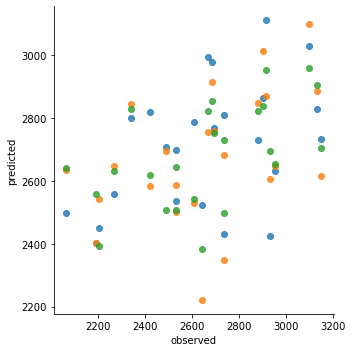

In [68]:
models = ["NCEP", "UKMO", "ECMWF"]
init_months = list(range(9,10))
for im in init_months:
    results = pd.DataFrame(columns=["observed", "predicted", "model"])
    for model in models:
        res = hf.kfold_cross_validation(kfold_cv_dataset, model=model, init=im, no_of_features=8)
        res = res.loc[:, ["yield", "predicted"]].assign(model=model).rename(columns={"yield":"observed"})
        results = pd.concat([results, res], ignore_index=True)
        
sns.lmplot(x="observed", y="predicted", data=results, fit_reg=False, hue="model", legend=False)
#ax.scatter(res["yield"].values, res["predicted"].values);
#ax.plot([res["yield"].values.min(), res["yield"].values.max()], [res["yield"].values.min(), res["yield"].values.max()], 'k--', lw=2);
#ax.set_xlabel('Measured');
#ax.set_ylabel('Predicted');
#name = str(im)
#plt.savefig(name + ".svg")
#plt.show();

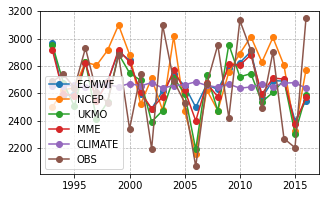

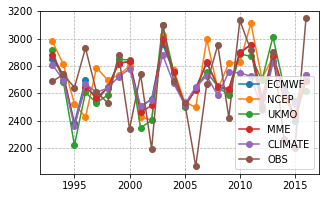

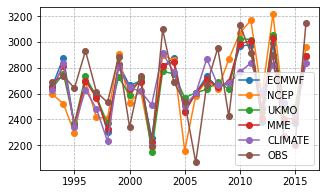

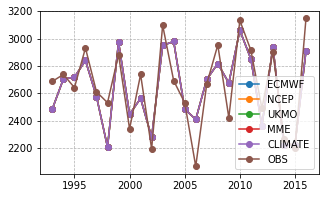

In [37]:
models = ["ECMWF", "NCEP", "UKMO", "MME", "CLIMATE"]
init_months = list(range(8,12))
for im in init_months:
    results = pd.DataFrame(0, index=models + ["OBS"], columns=list(range(1993,2017)))
    for model in models:
        res = hf.kfold_cross_validation(kfold_cv_dataset, model=model, init=im, no_of_features=8)
        #print(res["yield"].mean())
        results.loc["OBS", :] = res["yield"].values
        results.loc[model, :] = res["predicted"].values
    ax = results.transpose().plot(figsize=(5,3), marker='o')
    ax.grid('on', which='both', axis='y', linestyle='--', linewidth=.7)
    ax.grid('on', which='both', axis='x', linestyle='--', linewidth=.7)
    name = str(im)
    #plt.savefig(name + ".svg")
    plt.show()

### 8.3 Figure 3

In [240]:
features_bias = features_complete.sort_values(by=["model", "init_month", "zone", "year"]).reset_index(drop=True)
features_ws = features_bias.loc[features_bias["model"] == "WS"].reset_index(drop=True).copy().set_index(["model", "init_month", "zone", "year"])
features_models = features_bias.loc[features_bias["model"] != "WS"].reset_index(drop=True).copy().set_index(["model", "init_month", "zone", "year"])
features_models.loc[:, features_models.columns] = features_models.values - pd.concat([features_ws] * 40, ignore_index=False).values

In [241]:
mae_models = features_models.reset_index().drop(columns=["zone", "year"], axis=1).groupby(["model", "init_month"]).mean().abs()

In [242]:
mme_mae = mae_models.round(2).loc[(["MME"]), ["Rain_Aug", "Rain_Sep", "Rain_Oct"]]
ukmo_mae = mae_models.round(2).loc[(["UKMO"]), [ "Rain_Aug", "Rain_Sep", "Rain_Oct"]]
ncep_mae = mae_models.round(2).loc[(["NCEP"]), [ "Rain_Aug", "Rain_Sep", "Rain_Oct"]]
ecmwf_mae = mae_models.round(2).loc[(["ECMWF"]), [ "Rain_Aug", "Rain_Sep", "Rain_Oct"]]
climate_mae = mae_models.round(2).loc[(["CLIMATE"]), [ "Rain_Aug", "Rain_Sep", "Rain_Oct"]]

difference_ukmo = (ukmo_mae.reset_index().set_index("init_month").drop(columns=["model"]) - mme_mae.reset_index().set_index("init_month").drop(columns=["model"])).round(2).replace({0:np.nan})
difference_ncep = (ncep_mae.reset_index().set_index("init_month").drop(columns=["model"]) - mme_mae.reset_index().set_index("init_month").drop(columns=["model"])).round(2).replace({0:np.nan})
difference_ecmwf = (ecmwf_mae.reset_index().set_index("init_month").drop(columns=["model"]) - mme_mae.reset_index().set_index("init_month").drop(columns=["model"])).round(2).replace({0:np.nan})
difference_climate = (climate_mae.reset_index().set_index("init_month").drop(columns=["model"]) - mme_mae.reset_index().set_index("init_month").drop(columns=["model"])).round(2).replace({0:np.nan})

<AxesSubplot:ylabel='init_month'>

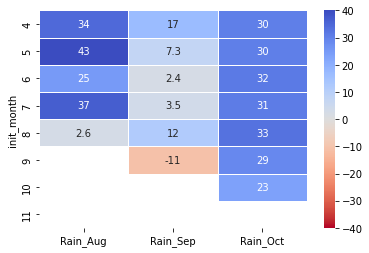

In [243]:
sns.heatmap(cmap="coolwarm_r", vmax=40, vmin=-40, data=difference_ukmo, annot=True, linewidths=1, linecolor="white")
plt.savefig("ukmo_mme_rain.svg")

<AxesSubplot:ylabel='init_month'>

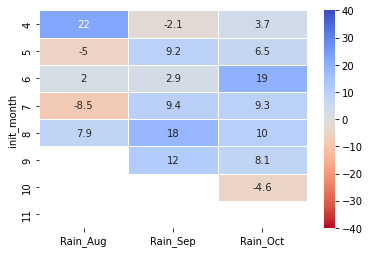

In [244]:
sns.heatmap(cmap="coolwarm_r", vmax=40, vmin=-40, data=difference_ncep, annot=True, linewidths=1, linecolor="white")
plt.savefig("ncep_mme_rain.svg")

<AxesSubplot:ylabel='init_month'>

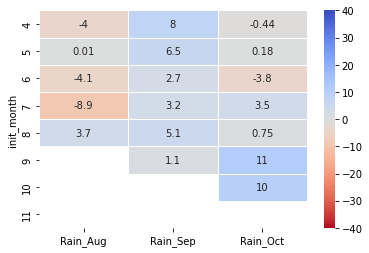

In [245]:
sns.heatmap(cmap="coolwarm_r", vmax=40, vmin=-40, data=difference_ecmwf, annot=True, linewidths=1, linecolor="white")
plt.savefig("ecmwf_mme_rain.svg")

<AxesSubplot:ylabel='init_month'>

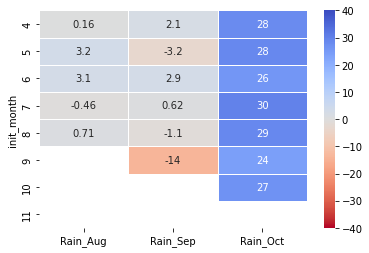

In [246]:
sns.heatmap(cmap="coolwarm_r", vmax=40, vmin=-40, data=difference_climate, annot=True, linewidths=1, linecolor="white")
plt.savefig("climate_mme_rain.svg")

## 8.4 Figure 4

In [133]:
# K-Fold Cross Validation
def feature_importance(data):
   
    # Features
    relevant_columns = [c for c in data.columns if c not in ["model", "init_month", "year", "yield"]]
    coefs_dict = dict(zip(relevant_columns, list(np.zeros(len(relevant_columns)))))
    
    for season in crop_seasons:
        X_train = data.loc[(data["model"] == "WS") 
                                 & (data["year"] != season), relevant_columns].reset_index(drop=True)
        y_train = data.loc[(data["model"] == "WS") 
                                 & (data["year"] != season), "yield"].reset_index(drop=True)
            
        pipeline = Pipeline([('scaler', StandardScaler()), 
                             ('var', VarianceThreshold()), 
                             ('selector', SelectKBest(f_regression, k=9)),
                             ('estimator', Ridge())])
        
        reg = pipeline.fit(X_train, y_train) 
        current_coef_dict = dict(zip(reg["selector"].get_feature_names_out(relevant_columns), reg["estimator"].coef_))
        coefs_dict = {k: coefs_dict.get(k, 0) + current_coef_dict.get(k, 0) for k in set(coefs_dict)}
        
    return coefs_dict

In [134]:
coefs = (np.
         round(pd
               .DataFrame(index=[0], 
                          data=feature_importance(kfold_cv_dataset))
               .transpose()
               .rename(columns={0:"coef"})
               .sort_values(by="coef") / 24, 2))

In [109]:
coefs = coefs.reset_index()

In [111]:
coefs["location"] = coefs["index"].str[-1:]

In [115]:
coefs["month"] = coefs["index"].str[-5:-2]

In [118]:
coefs["var"] = coefs["index"].str[:-6]

In [122]:
coefs = coefs.drop(columns=["index"])

In [129]:
coefs["climate_var"] = coefs["month"] + "_" + coefs["var"]

In [130]:
coefs.pivot(index="climate_var", columns="location", values="coef")

location,1,2,3,4
climate_var,,,,
Aug_Rain,0.00,0.00,0.00,0.00
Aug_Tmean,15.75,-51.59,-6.65,-95.55
Oct_Rain,0.00,0.00,0.00,0.00
Oct_Tmean,-57.12,12.29,-150.49,22.62
Sep_Rain,-1.97,3.03,-60.03,-74.30
Sep_Tmean,0.00,0.00,0.00,0.00
